# Folding 4FGL J0318.2+0254 using Lattice Algorithms

## 1. Initializations

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import fpylll
from g6k import Siever

## 2. Load the data

Here we load the a dictionary containing all the data we will need.

In [2]:
data_needed = np.load('data/data.npy',
                      allow_pickle=True).tolist()

Data is orginised as follows:

1. *toas_met_lattice* : the times of arrival (TOAs) in Fermi mission elapsed time (met), for the lattice.
2. *toas_location_lattice* : Fermi's location w.r.t the solar system barycenter, a location per TOA.
3. *span_vecs* : the timing vectors used (similar to $\vec{t}$, $\frac{1}{2}\vec{t}^2$, etc.).
4. *coeff_std* : the extent of the (orthonormalized) timing vectors coefficients to search for.
5. *lattice* : the lattice's basis, in its natural form.
6. *integer_lattice* : the lattice's basis, rescaled and rounded.
7. *mul_factor* : the lattice's scaling factor.
8. *expected_sigma* : the expected length of the shortest vector in the lattice, according to the Gaussian heuristic.
9. *toas_met_verify* : the times of arrival (TOAs) in Fermi mission elapsed time (met), for the verification step.
10. *toas_location_verify* : Fermi's location w.r.t the solar system barycenter, a location per verification TOA.
11. *probs_verify* : the verification TOA's association probabilities.
12. *transformation_matrix* : inverse of the orthogonalization transformation of *span_vecs*, used to fold the verification TOAs according to the solutions on the lattice TOAs.

In [3]:
integer_lattice         = data_needed['integer_lattice']
coeff_std               = data_needed['coeff_std']
toas_met_lattice        = data_needed['toas_met_lattice']
span_vecs_lattice       = data_needed['span_vecs']
transformation_matrix   = data_needed['transformation_matrix']
mul_factor              = data_needed['mul_factor']
toas_met_verify         = data_needed['toas_met_verify']
probs_verify            = data_needed['probs_verify']

## 3. Executing the lattice algorithm

First, we set up the lattice in the fpylll's library format.

In [4]:
integer_matrix = fpylll.IntegerMatrix.from_iterable(*integer_lattice.shape,
                                                    list(map(int, list(integer_lattice.flatten()))))
gso = fpylll.GSO.Mat(integer_matrix, flags=fpylll.GSO.INT_GRAM,
                     U=fpylll.IntegerMatrix.identity(integer_matrix.nrows),
                     UinvT=fpylll.IntegerMatrix.identity(integer_matrix.nrows))

Second, we reduce the lattice using a BKZ(30) lattice reduction algorithm.

The lattice reduction results in a more balanced basis for the lattice (basis vectors are closer in length), which is easier to use for enumeration or sieving.

In [5]:
bkz = fpylll.BKZ.Reduction(gso, fpylll.LLL.Reduction(gso, delta=0.95),
                           fpylll.BKZ.Param(block_size=30, strategies=fpylll.BKZ.DEFAULT_STRATEGY, delta=0.95))
_   = bkz()

Third, we sieve succesively on larger and larger sublattices (this operation is called *pump* in G6K).

This step results in many short vectors in the lattice, some of them might be our sought after solution.

In [6]:
g6k = Siever(gso)
g6k.initialize_local(0, integer_lattice.shape[0]//2, integer_lattice.shape[0])
with g6k.temp_params(otf_lift=False):
    while g6k.l > len(coeff_std):
        g6k.extend_left(1)
        g6k(alg='hk3')
    g6k.extend_left(len(coeff_std))

Lastly, we read the sieve results and save them in various formats:
1. *raw* : are the coefficients of the reduced basis.
2. *transformation* : are the coefficients of the original basis (split to $\vec{k}$ and the timing parameters).
3. *vectors* : are the folds.

In [7]:
db_raw = np.array(list(g6k.itervalues()))
db_transformation = db_raw @ np.array(list(g6k.M.U))
db_transformation_k = db_transformation[:, :len(toas_met_lattice)]
db_transformation_p = db_transformation[:, len(toas_met_lattice):]
db_vectors = db_raw @ np.array(list(g6k.M.B))

## 4. Verification

Folding the verification TOA's according to the sieving results and calculation the Q statistic

In [8]:
verify_fold = np.mod(db_transformation_p @ transformation_matrix / mul_factor + 0.5, 1) - 0.5
Q_stat_normalization = np.sum(probs_verify ** 2 / 2)
Q_stat = np.abs(np.sum(probs_verify * np.exp(1j * 2*np.pi * verify_fold), axis=1)) ** 2 / Q_stat_normalization

Filtering out unphysical solutions, that don't make a significant number of phase revolutions

In [9]:
reasnable_solutions_mask = np.std(db_transformation_k, axis=1) > 1e5

Plotting the Q statistic histogram.

We can clearly see the population of null solutions and the population of true solutions.

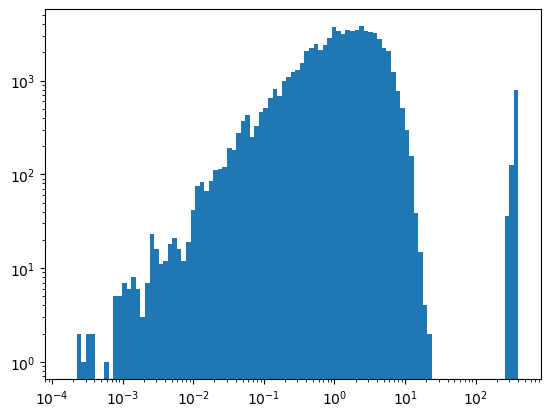

In [10]:
bins = np.logspace(np.log10(min(Q_stat[reasnable_solutions_mask])), 
                   np.log10(max(Q_stat[reasnable_solutions_mask])), 100)
plt.hist(Q_stat[reasnable_solutions_mask], bins=bins)
plt.xscale('log')
plt.yscale('log')
plt.show()

Looking at the fold of one of the detections we can clearly see the pulse.

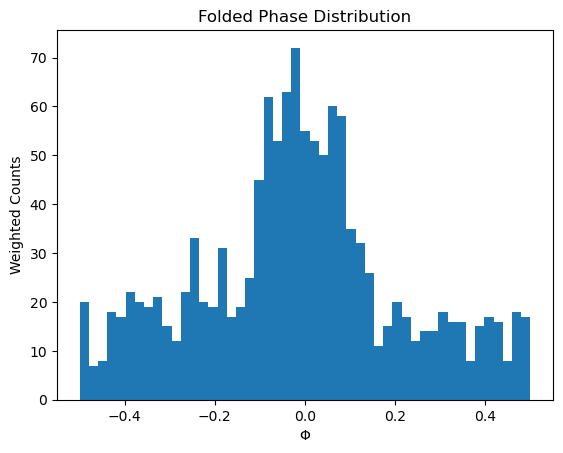

In [11]:
plt.hist(verify_fold[reasnable_solutions_mask][np.argmax(Q_stat[reasnable_solutions_mask])], 
         bins=np.linspace(-0.5, 0.5, 50))
plt.xlabel(r'$\Phi$')
plt.ylabel('Weighted Counts')
plt.title('Folded Phase Distribution')
plt.show()

## 6. Looking at the vectors

We can see the vectors correspond to the different parameters

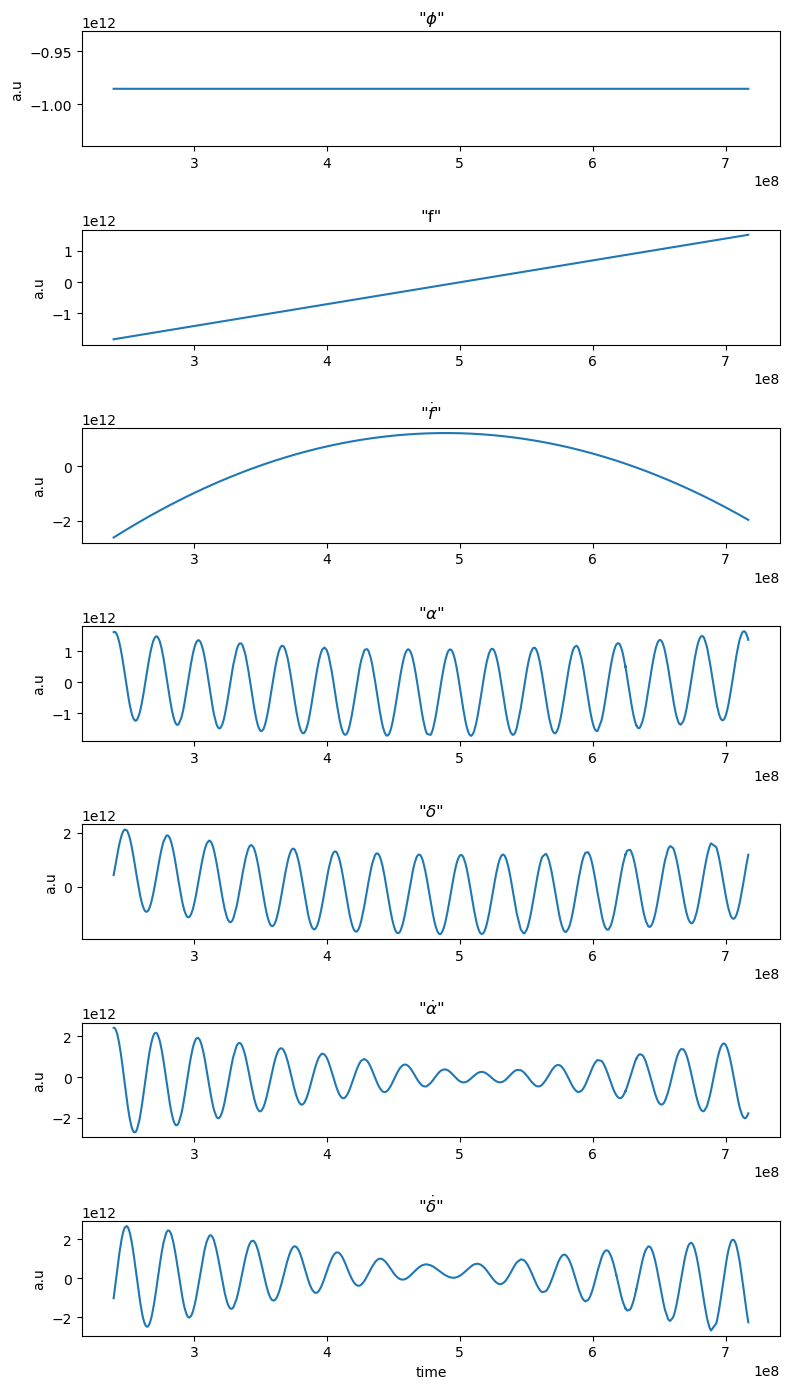

In [12]:
labels = [r'"$\phi$"', '"f"', r'"$\dot{f}$"', r'"$\alpha$"', r'"$\delta$"', r'"$\dot{\alpha}$"', r'"$\dot{\delta}$"']
plt.subplots(nrows=7, ncols=1, figsize=(8, 14))
for idx in range(7):
    plt.subplot(7, 1, idx+1)
    plt.plot(toas_met_verify, transformation_matrix[idx], label=labels[idx])
    plt.ylabel('a.u')
    plt.title(labels[idx])

plt.xlabel('time')
plt.tight_layout()
plt.show()